##  Градиентные методы оптимизации

In [15]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(9,9)
import pandas as pd
import numpy as np
import scipy
from IPython import display
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

Класс для визуализации методов оптимизации

In [2]:
import numpy as np
import math
import time
import re
from sympy.tensor.array import derive_by_array
from sympy import diff, symbols, Symbol, exp, cos, sin, log, pi, lambdify, hessian, Matrix

class dynamic_plot_optimisation():
    
    def __init__(self, func, alpha, xlim, init_point=None, iters=20, tol=1e-3, 
                 ylim=None, grad=None, hess=None, trace_x=True, keep_track=False,
                 method='GD', criterion='x', frequancy=1, contour=[1, 1000]):
        self.init_x = init_point
        self.contour = contour
        self.alpha = alpha
        self.iters = iters
        self.keep_track = keep_track
        self.tol = tol
        self.xlim = xlim
        self.ylim = ylim
        self.func = func
        self.init_point = init_point
        self.grad = grad
        self.hess = hess
        self.trace_x = trace_x
        self.method = method
        self.criterion = criterion
        self.frequancy = frequancy
        self.x, self.y = symbols(['x', 'y'])
        if self.ylim is not None:
            self.variables = [self.x, self.y]
        else:
            self.variables = [self.x]
        self.dimention = len(self.variables)
        
    def compute_grad(self):
        matrix_scalar_function = Matrix([self.func])
        return lambdify(self.variables, matrix_scalar_function.jacobian(self.variables)), matrix_scalar_function.jacobian(self.variables)
            

    def compute_hess(self):
        return lambdify(self.variables, hessian(eval(self.func), self.variables)), hessian(eval(self.func), self.variables)

    
    def initialize_point(self):
        if self.init_point is not None:
            return self.init_point
        else: 
            if self.dimention == 1:
                _ = np.random.uniform(self.xlim[0], self.xlim[1])
            else:
                _ = [np.random.uniform(self.xlim[0], self.xlim[1]), np.random.uniform(self.ylim[0], self.ylim[1])]
            return _
        
    def gradient_step(self, old_point, method=None):
        if method is None:
            method = self.method
        else:
            method = method
            
        if self.dimention == 2:
            e1, e2 = old_point
            if method == 'GD':
                grad_old = self.compute_grad()[0](e1, e2)
                new_point = np.array(old_point).reshape(-1, 1) - self.alpha*np.array(grad_old).reshape(-1, 1)
            else:
                grad_old = self.compute_grad()[0](e1, e2)
                hess_old = self.compute_hess()[0](e1, e2)
                new_point = np.array(old_point).reshape(-1, 1) - self.alpha*np.linalg.inv(hess_old).dot(np.array(grad_old).reshape(-1, 1))
            return new_point.squeeze()
        
        else:
            if type(old_point) == list:
                e1 = old_point[0]
            else:
                e1 = old_point
            if self.method == 'GD':
                grad_old = self.compute_grad()[0](e1)[0]
                new_point = old_point - self.alpha*grad_old
            else:
                grad_old = self.compute_grad()[0](e1)[0]
                hess_old = self.compute_hess()[0](e1)[0][0]
                new_point = old_point - self.alpha*(grad_old/hess_old)
            return new_point
            
    
        
    def plot_1d_optimisation(self):

        '''method is one of [GD, Newtone], if method == 'Newtone', than hess is required'''
        '''func, grad and hess are functions without numpy (strings), example func = str(11*x**2 + 15*x - 3*sin(x**3)) '''
        '''criterion is one of [x, grad]'''

        try:

            rep = {"np.cos": "cos", "np.sin": "sin", 'np.exp': 'exp', 'np.log': 'log'} # define desired replacements here
            rep = dict((re.escape(k), v) for k, v in rep.items())
            pattern = re.compile("|".join(rep.keys()))

        #     Автоматическое вычисление градиента и гессиана с помощью sympy
            if self.grad is None:
                func = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.func)
                grad = str(diff(func))
                if self.method == 'Newtone':
                    hess = str(diff(grad))
            else:
                func = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.func)
                grad = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.grad)
                if self.method == 'Newtone':
                    hess = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.hess)

        #     Добавление numpy
            replace_reverse = {x: y for y, x in rep.items()}
            replace_reverse = dict((re.escape(k), v) for k, v in replace_reverse.items())
            pattern = re.compile("|".join(replace_reverse.keys()))

            func = pattern.sub(lambda m: replace_reverse[re.escape(m.group(0))], func)
            grad = pattern.sub(lambda m: replace_reverse[re.escape(m.group(0))], grad)


            func_x = lambda x: eval('{}'.format(func.replace("\.", '.')))
            grad_x = lambda x: eval('{}'.format(grad.replace("\.", '.')))
            if self.method == 'Newtone':
                hess = pattern.sub(lambda m: replace_reverse[re.escape(m.group(0))], hess)
                hess_x = lambda x: eval('{}'.format(hess.replace("\.", '.')))
            x_dom = np.linspace(self.xlim[0], self.xlim[1], 1000)
            f_x = func_x(x_dom)
            grad_hist_norm = [0, 1]
            x_k = self.initialize_point()
            hist_x_k = [x_k-1, x_k]
            if self.criterion=='grad':
                crit = grad_hist_norm
            else:
                crit = hist_x_k
            i = 0

            while np.linalg.norm(crit[i] - crit[i+1]) > self.tol and i <= self.iters:
                plt.figure(figsize=(9,9))
                plt.plot(x_dom, f_x)
                if self.trace_x:
                    plt.scatter(x_k, func_x(x_k), s=70, c='red', label='{} iter, ({})'.format(i, np.round(x_k, decimals=4)))
                else:
                    plt.scatter(x_k, func_x(x_k), s=70, c='red', label='{} iter'.format(i))
                plt.xlim(self.xlim[0], self.xlim[1])
                plt.legend(fontsize=15)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                time.sleep(self.frequancy)
                grad_x_k = grad_x(x_k)
                x_k = self.gradient_step(old_point=x_k)[0]
                grad_hist_norm.append(grad_x_k)
                hist_x_k.append(x_k)
                if self.criterion=='grad':
                    crit = grad_hist_norm
                else:
                    crit = hist_x_k
                i += 1

            plt.figure(figsize=(9,9))
            plt.plot(x_dom, f_x)
            if self.trace_x:
                plt.scatter(x_k, func_x(x_k), s=70, c='red', label='{} iter, ({})'.format(i, np.round(x_k, decimals=4)))
            else:
                plt.scatter(x_k, func_x(x_k), s=70, c='red', label='{} iter'.format(i))
            plt.xlim(self.xlim[0], self.xlim[1])
            plt.legend(fontsize=15)
            display.clear_output()
            display.display(plt.gcf())
            time.sleep(self.frequancy)
            return x_k, func_x(x_k)

        except KeyboardInterrupt:

            return x_k, func_x(x_k)

        
    def plot_2d_optimisation(self):

        '''method is one of [GD, Newtone], if method == 'Newtone', than hess is required'''
        '''func, grad and hess are functions without numpy (strings), example func = str(11*x**2 + 15*x - 3*sin(x**3)) '''
        '''criterion is one of [x, grad]'''

        try:

            rep = {"np.cos": "cos", "np.sin": "sin", 'np.exp': 'exp', 'np.log': 'log'} # define desired replacements here
            rep = dict((re.escape(k), v) for k, v in rep.items())
            pattern = re.compile("|".join(rep.keys()))

        #     Автоматическое вычисление градиента и гессиана с помощью sympy
            if self.grad is None:
                func = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.func)
                grad = cla.compute_grad()[1]
                if self.method == 'Newtone':
                    hess = cla.compute_hess()[1]
            else:
                func = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.func)
                grad = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.grad)
                if self.method == 'Newtone':
                    hess = pattern.sub(lambda m: rep[re.escape(m.group(0))], self.hess)

        #     Добавление numpy
            replace_reverse = {x: y for y, x in rep.items()}
            replace_reverse = dict((re.escape(k), v) for k, v in replace_reverse.items())
            pattern = re.compile("|".join(replace_reverse.keys()))

            func = pattern.sub(lambda m: replace_reverse[re.escape(m.group(0))], func)


            func_x = lambda x: eval('{}'.format(func.replace("\.", '.')))

            x_dom = np.linspace(self.xlim[0], self.xlim[1], 1000)
            grad_hist_norm = [0, 1]
            x_k = self.initialize_point()
            hist_x_k = [list(np.array(x_k)-np.array([1]*len(self.variables))), x_k]
            if self.criterion=='grad':
                crit = grad_hist_norm
            else:
                crit = hist_x_k
            i = 0

            while np.linalg.norm(crit[i] - crit[i+1]) > self.tol and i <= self.iters:
                plt.figure(figsize=(8,8))
                dom_x = np.linspace(self.xlim[0], self.xlim[1], 500)
                dom_y = np.linspace(self.ylim[0], self.ylim[1], 500)
                x_, y_ = np.meshgrid(dom_x, dom_y)
                Z = eval('{}'.format(self.func).replace('x', 'x_').replace('y', 'y_'))
                V = np.linspace(self.contour[0], self.contour[1], self.contour[2])
                cs = plt.contour(x_,y_,Z,V,cmap='jet')
                plt.clabel(cs)
                plt.grid()
                if self.keep_track:
                    if self.trace_x:
                        plt.scatter(np.array(hist_x_k)[:,0], np.array(hist_x_k)[:,1], c='red', s=70)
                        plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter, ({})'.format(i, np.round(x_k, decimals=4)))
                    else:
                        plt.scatter(np.array(hist_x_k)[:,0], np.array(hist_x_k)[:,1], c='red', s=70)
                        plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter'.format(i))
                else:
                    if self.trace_x:
                        plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter, ({})'.format(i, np.round(x_k, decimals=4)))
                    else:
                        plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter'.format(i))
                plt.xlim(self.xlim[0], self.xlim[1])
                plt.legend(fontsize=15)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                time.sleep(self.frequancy)
                e1, e2 = x_k
                grad_x_k = self.compute_grad()[0](e1, e2)
                x_k = self.gradient_step(old_point=x_k)
                grad_hist_norm.append(grad_x_k)
                hist_x_k.append(x_k)
                if self.criterion=='grad':
                    crit = grad_hist_norm
                else:
                    crit = hist_x_k
                i += 1

            plt.figure(figsize=(8,8))
            dom_x = np.linspace(self.xlim[0], self.xlim[1], 500)
            dom_y = np.linspace(self.ylim[0], self.ylim[1], 500)
            wx_, y_ = np.meshgrid(dom_x, dom_y)
            Z = eval('{}'.format(self.func).replace('x', 'x_').replace('y', 'y_'))
            V = np.linspace(self.contour[0], self.contour[1], self.contour[2])
            cs = plt.contour(x_,y_,Z,V,cmap='jet')
            plt.clabel(cs)
            plt.grid()
            if self.trace_x:
                plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter, ({})'.format(i, np.round(x_k, decimals=4)))
            else:
                plt.scatter(x_k[0], x_k[1], s=70, c='red', label='{} iter'.format(i))
            plt.xlim(self.xlim[0], self.xlim[1])
            plt.legend(fontsize=15)
            display.clear_output()
            display.display(plt.gcf())
            time.sleep(self.frequancy)
            return x_k

        except KeyboardInterrupt:
            
            return x_k
        
        except AttributeError:
            
            
            return x_k

### Теория оптимизации

Имеем: $\ f(x) \to \min\limits_{x}$, $\quad x \in \mathbb{R}^n, \quad f : \mathbb{R}^n \to \mathbb{R}  $

${\bf \text{Необходимое условие экстремума:}}$ 

$\quad$ Если $x^{\ast}$ - точка локального экстремума (минимума/максимума) $\quad \Rightarrow \quad \nabla f(x^{\ast}) = 0$

${\bf \text{Достаточное условие экстремума:}}$ 

$\quad$ Если $x^{\ast}$ - точка локального минимума (максимума) $\quad \Rightarrow \quad \nabla^2 f(x^{\ast}) > 0 \quad (< 0), \qquad \left(\nabla^2 f(x) - \text{матрица Гессиан}\right)$


Однако, не всегда удаётся аналитически решить уравнение, соответствующее необходимому условию.

${\bf \text{Пример:}}$

$f(x) = -0.3 \cdot \log(x)^3 + 3 \cdot x^5 - \log(1 - x^5) \to \min\limits_{x}$

$f'(x) = 15 \cdot x^4 + \frac{5 \cdot x^4}{1 - x^5} - \frac{0.9 \cdot \log^2(x)}{x} = 0$ - Это уравнение не разрешимо относительно переменной $x$ аналитически. Придётся прибегать к численным методам. 

График функции $f(x)$ изображён на (Рис. 1). Видно, что у функции есть точка локального минимума (она же является глобальным минимумом)

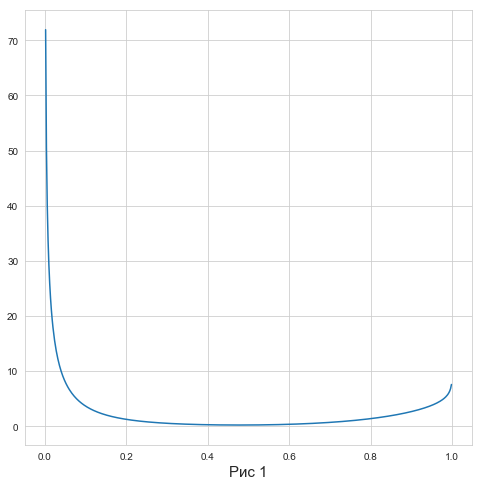

In [16]:
xx = np.linspace(0, 1, 500)
y1 = lambda x: -0.3*np.log(x)**3 + 3*x**5 - np.log(1 - x**5)
plt.figure(figsize=(8,8))
plt.xlabel(u'Рис 1', fontsize=15)
plt.plot(xx, y1(xx));

## Метод Градиентного спуска (GD - gradient descent)

Идея метода заключается в следующем: градиент $\left( \nabla f(x) \right)$ - это вектор, который показывает направление наискорейшего роста функции. Тогда направление, задаваемое вектором $- \nabla f(x)$ будет вести к наискорейшему убыванию значения функции $f(x)$.  

${\bf GD:}$

$x_{new} = x_{old} - \nabla f(x_{old})$

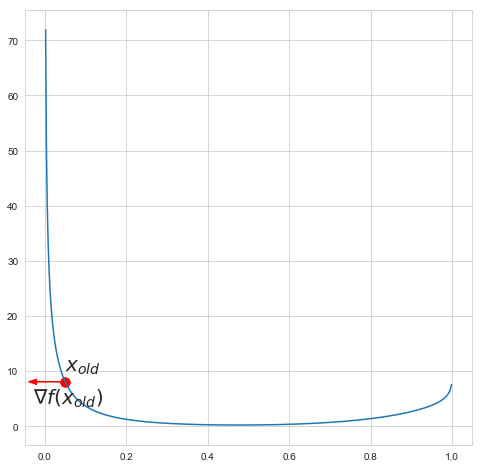

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(0.05, y1(0.05), s=90, color='red')
plt.arrow(0.05, y1(0.05), -0.07, 0, head_width=1, head_length=0.02, color='red')
plt.text(-0.03, 4, r'$\nabla f(x_{old})$', fontsize=20)
plt.text(0.05, 10, r'$x_{old}$', fontsize=20)
plt.plot(xx, y1(xx));

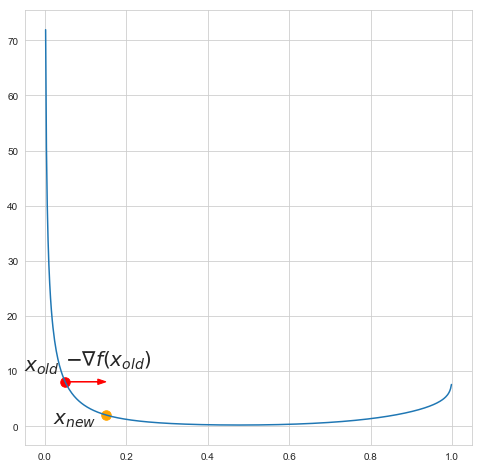

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(0.05, y1(0.05), s=90, color='red')
plt.arrow(0.05, y1(0.05), 0.08, 0, head_width=1, head_length=0.02, color='red')
plt.text(0.05, 11, r'$-\nabla f(x_{old})$', fontsize=20)
plt.text(-0.05, 10, r'$x_{old}$', fontsize=20)
plt.text(0.02, 0.5, r'$x_{new}$', fontsize=20)
plt.scatter(0.15, y1(0.15), s=90, color='orange')
plt.plot(xx, y1(xx));

Далее $x_{new}$ становится новой начальной точкой ($x_{old}$) и итерации продолжаются, пока не будет выполнен критерий останова (разность по аргументу меньше порога, разность по функции меньше порога, разность по норме градиента меньше порога, и т.д.)

Динамическая визуализация GD

In [20]:
func = '-0.3*log(x)**3 + 3*x**5 - log(1 - x**5)'
x, y =  symbols(['x', 'y'])
cla = dynamic_plot_optimisation(func=func, xlim=[0,1], init_point=0.1, ylim=None, 
                                alpha=0.01, keep_track=True, trace_x=True, method='GD', 
                                frequancy=0.5, criterion='grad', contour=[0, 300, 40])

In [41]:
cla.plot_1d_optimisation()

В многомерном случае картина аналогичная.

${\bf \text{Пример:}}$

$f(x, y) = 2x^2 - xy + y^2 - 2x - 15y \to \min\limits_{x, y} \quad $ 

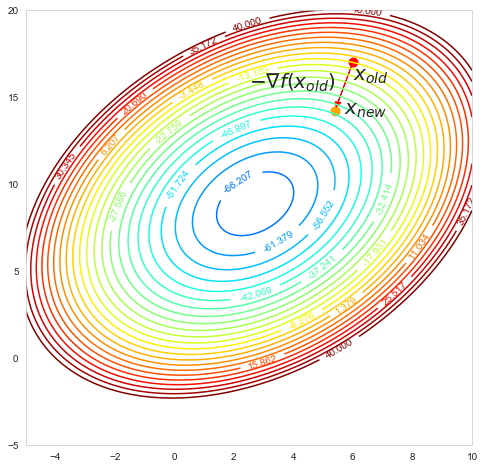

In [24]:
plt.figure(figsize=(8,8))
dom_x = np.linspace(-5, 10, 500)
dom_y = np.linspace(-5, 20, 500)
x_, y_ = np.meshgrid(dom_x, dom_y)
Z = 2*x_**2 - x_*y_ + y_**2 - 2*x_ - 15*y_
V = np.linspace(-100, 40, 30)
cs = plt.contour(x_,y_,Z,V,cmap='jet')
plt.scatter(6, 17, s=80, c='red')
plt.text(6, 16, u'$x_{old}$', fontsize=20)
plt.arrow(6, 17, -0.5, -2.3, head_width=0.2, color='red')
plt.text(2.5, 15.5, r'$ - \nabla f(x_{old})$', fontsize=20)
plt.scatter(5.4, 14.2, s=80, c='orange')
plt.text(5.7, 14.0, u'$x_{new}$', fontsize=20)
plt.clabel(cs)
plt.grid()

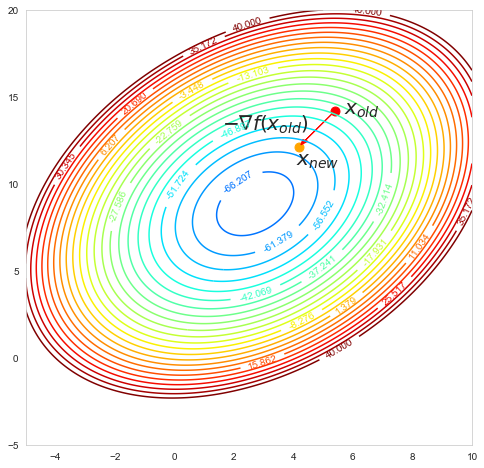

In [25]:
plt.figure(figsize=(8,8))
dom_x = np.linspace(-5, 10, 500)
dom_y = np.linspace(-5, 20, 500)
x_, y_ = np.meshgrid(dom_x, dom_y)
Z = 2*x_**2 - x_*y_ + y_**2 - 2*x_ - 15*y_
V = np.linspace(-100, 40, 30)
cs = plt.contour(x_,y_,Z,V,cmap='jet')
plt.scatter(5.4, 14.2, s=80, c='red')
plt.text(5.7, 14.0, u'$x_{old}$', fontsize=20)
plt.arrow(5.4, 14.2, -1, -1.7, head_width=0.2, color='red')
plt.scatter(4.2, 12.1, s=80, color='orange')
plt.text(4.1, 11.1, u'$x_{new}$', fontsize=20)
plt.text(1.6, 13.1, r'$ - \nabla f(x_{old})$', fontsize=20 )
plt.clabel(cs)
plt.grid()

Динамическая визуализация

In [26]:
func = '2*x**2 - x*y + y**2 - 2*x - 15*y'
x, y =  symbols(['x', 'y'])
cla = dynamic_plot_optimisation(func=func, xlim=[-5,10], init_point=[2,17], ylim=[-5,20], 
                                alpha=0.1, keep_track=True, trace_x=True, method='GD', 
                                frequancy=0.5, criterion='grad', contour=[-100, 30, 20])

In [42]:
cla.plot_2d_optimisation()

## Метод Ньютона (NM)

Идея метода: строится квадратичная аппроксимация (по методу Тейлора) данной функции в окрестности текущей точки $x_{old}$. Новая точка $x_{new}$ является точкой минимума этой квадратичной аппроксимации.

$f(x_{old} + \epsilon) \approx f(x_{old}) +  f'(x_{old}) \cdot \epsilon + \frac{1}{2} \cdot f''(x_{old}) \cdot \epsilon^2  \to \min\limits_{\epsilon} $

$f'_{\epsilon}(x_{old} + \epsilon) =   f'(x_{old}) + f''(x_{old}) \cdot \epsilon = 0 \quad  \Rightarrow \quad \boxed{\epsilon^{\ast} = - \frac{f'(x_{old})}{f''(x_{old})}}  $

Итак: $x_{new} = x_{old} + \epsilon \quad \Rightarrow \quad \boxed{x_{new} =  x_{old}  - \frac{f'(x_{old})}{f''(x_{old})}}$

В многомерном случае формула принимает вид: $\quad  x_{new} = x_{old} - \nabla^2 f(x_{old})^{-1} \cdot \nabla f(x_{old}), \qquad \nabla^2 f(x_{old})^{-1}$ - обратная к матрице Гессиан  

In [28]:
y2 = lambda x: -3*np.log(x) - 3*x - np.log(1 - x**2)
y3 = lambda x: 6.61781 - 32.798*(x - 0.1) + 151.031*(x - 0.1)**2
plt.figure(figsize=(8, 8))
plt.scatter(0.1, y2(0.1), c='red', s=80)
plt.text(0.12, y2(0.1), u'$x_{old}$', fontsize=20)
plt.plot(xx, y3(xx), color='orange')
plt.ylim(-1, 12.5)
plt.scatter(0.209, y2(0.209), s=80, c='orange')
plt.text(0.22, y2(0.209), u'$x_{new}$', fontsize=20)
plt.plot(xx, y2(xx));

In [29]:
y2 = lambda x: -3*np.log(x) - 3*x - np.log(1 - x**2)
y3 = lambda x: 4.11393 - 16.917*(x - 0.209) + 35.4811*(x - 0.209)**2
plt.scatter(0.209, y2(0.209), c='red', s=80)
plt.text(0.209, y2(0.209)+0.5, u'$x_{old}$', fontsize=20)
plt.plot(xx, y3(xx), color='orange')
# plt.ylim(-1, 12.5)
plt.scatter(0.447, y2(0.447), s=80, c='orange')
plt.text(0.458, y2(0.447), u'$x_{new}$', fontsize=20)
plt.plot(xx, y2(xx));

Динамическая визуализация

In [30]:
func = '-3*log(x) - 3*x - log(1 - x**2)'
x, y =  symbols(['x', 'y'])
cla = dynamic_plot_optimisation(func=func, xlim=[0,1], init_point=0.1, ylim=None, 
                                alpha=1, keep_track=True, trace_x=True, method='Newtone', 
                                frequancy=0.5, criterion='grad', contour=[0, 300, 40])

In [43]:
cla.plot_1d_optimisation()

In [34]:
func = '2*x**2 - x*y + y**2 - 2*x - 15*y'
x, y =  symbols(['x', 'y'])
cla = dynamic_plot_optimisation(func=func, xlim=[-5,10], init_point=[2,17], ylim=[-5,20], 
                                alpha=1, keep_track=True, trace_x=True, method='Newtone', 
                                frequancy=0.5, criterion='grad', contour=[-100, 30, 20])

In [46]:
cla.plot_2d_optimisation();

## Матричные производные

В машинном обучении часто приходится работать с объектами большой размерности (векторами, матрицами, тензорами), находить для них производные различных порядков. Для двумерного пространства это сделать не тяжело (как мы сделали это выше), а для пространста высоких порядков (например $\mathbb{R}^{100}$) находить вручную элементы матрицы Гессиана весьма проблематично (придётся вычислить $\frac{100 \cdot 101}{2}$ значений). Мы познакомимся с техникой матричного дифференцирования, которая справляется с этой проблемой более элегантно.

Имеем: $x \in \mathbb{R}^a, \quad f: \mathbb{R}^a \to \mathbb{R}^b$

Назовём матричной производной функции $f$ в точке $x$ $\quad \left( Df(x)[\Delta x]  \right)$ второй член в разложении Тейлора: 

$ \boxed{f(x + \Delta x) = f(x) + Df(x)[\Delta x] + o\left( \Vert \Delta x \Vert  \right)} \qquad (\ast) $

${\bf \text{Пример 1:}}$

$x \in \mathbb{R}^n, \quad f: \mathbb{R}^n \to \mathbb{R}, \quad f(x) = a^T x$

$f(x + \Delta x) = a^T(x + \Delta x) = \underbrace{a^Tx}_{f(x)} + \underbrace{a^T \Delta x}_{Df(x)[\Delta x]}$

Получаем, что $D(a^Tx)[\Delta x] = a^T\Delta x$


${\bf \text{Пример 2:}}$

$x \in \mathbb{R}^n, \quad f: \mathbb{R}^n \to \mathbb{R}, \quad f(x) = x^T A x$

$f(x + \Delta x) = (x^T + \Delta x^T) A (x + \Delta x) = \underbrace{x^TAx}_{f(x)} + \underbrace{x^TA\Delta x + xA\Delta x^T}_{Df(x)[\Delta x]} + \underbrace{\Delta x^TA\Delta x}_{o \left( \Vert \Delta x \Vert  \right) }$

Получаем, что $D(x^TAx)[\Delta x] = x^TA\Delta x + xA\Delta x^T$

Заметим, что определение $(\ast)$ эквивалентно: 

$\boxed{Df(x)[\Delta x] = \lim\limits_{t \to 0} \frac{f(x + \Delta x \cdot t) - f(x)}{t}}$

C помощью определения выше вычислим $D(det(X))[\Delta X]$, где $X$ - квадратная невырожденная матрица:

${\bf \text{Пример 3:}}$

$D(det(X))[\Delta X] = \lim\limits_{t \to 0} \frac{det(X + \Delta X \cdot t) - det(X)}{t} = \lim\limits_{t \to 0} \frac{det (X) \cdot det(I + X^{-1} \cdot \Delta X \cdot t) - det(X) }{t} = \lim\limits_{t \to 0} \frac{det(X) \cdot \left[ det(I + X^{-1} \cdot \Delta X \cdot t) - 1  \right]}{t}$

Пусть у матрицы $X^{-1} \cdot \Delta X$ собственные значения $\lambda_{i}$, тогда у матрицы $I + X^{-1} \cdot \Delta X \cdot t$ собственные значения будут $1 + t \cdot \lambda_{i}$. Вспомним, что определитель равен произведению собственных значений: $det(I + X^{-1} \cdot \Delta X \cdot t) = \prod\limits_{i=1}^n (1 + t \cdot \lambda_{i}) = 1 + t \cdot \underbrace{\sum\limits_{i=1}^n \lambda_{i}}_{tr(X^{-1} \cdot \Delta X)} + o(t) $. Подставляя это обратно в предел получаем:

$\lim\limits_{t \to 0} \frac{det(X) \cdot \left[ det(I + X^{-1} \cdot \Delta X \cdot t) - 1  \right]}{t} = \lim\limits_{t \to 0} \frac{det(X) \cdot \left[ 1 + tr(X^{-1} \cdot \Delta X) \cdot t - 1  \right]}{t} = det(X) \cdot tr(X^{-1} \cdot \Delta X)$

Получаем, что $D(det(X))[\Delta X] = det(X) \cdot tr(X^{-1} \cdot \Delta X)$

### Зачем же нужны эти матричные производные?

Оказывается, что для многомерных функций верны соответстующие утверждения про точки экстремума, как и в скалярном случае:

${\bf \text{Необходимое условие экстремума:}}$ 

$\quad$ Если $x^{\ast}$ - точка локального экстремума (минимума/максимума) $\quad \Rightarrow \quad D f(x^{\ast}) [\Delta x] = 0$

${\bf \text{Достаточное условие экстремума:}}$ 

$\quad$ Если $x^{\ast}$ - точка локального минимума (максимума) $\quad \Rightarrow \quad D^2 f(x^{\ast}) [\Delta x, \Delta x] > 0 \quad (< 0)$


Но как пользоваться этим $Df(x)[\Delta x]$, ведь в нём участвует загадочное $\Delta x$? Оказывается, что $Df(x)[\Delta x]$ можно выразить (в нашем случае так будет почти всегда) через привычные нам объекты - градиенты, якобианы и т.д.

$
1. \quad f: \mathbb{R} \to \mathbb{R} \Rightarrow Df(x)[\Delta x] = \nabla f(x) \cdot  \Delta x
$

$
2. \quad f: \mathbb{R}^n \to \mathbb{R} \Rightarrow Df(x)[\Delta x] = \nabla f(x)^T \Delta x
$

$
3. \quad f: \mathbb{R}^{m \times n} \to \mathbb{R} \Rightarrow Df(x)[\Delta x] = tr \left(\nabla f(x)^T \Delta x \right)
$

Во всех случаях объекты $\nabla f(x)$ будут размерности аргумента. То есть в первом случае $\nabla f(x) \in \mathbb{R}$ (обычная скалярная производная), во втором: $\nabla f(x) \in \mathbb{R}^n$ (градиент), в третьем: $\nabla f(x) \in \mathbb{R}^{m \times n}$ (матрица из производных по ij элеметну матрицы x).

Это уже те объекты с которыми мы привыкли работать, и тогда в случае векторного агрумента ($x \in \mathbb{R}^n$), условие $Df(x) [\Delta x] = 0$ превращается в условие: $\nabla f(x) = 0$ - привычное необходимое условие экстремума скалярной функции нескольких переменных. 

### Матричные производные высших порядков

$D^2f(x)[\Delta x_{1}, \Delta x_{2}] = D\left( Df(x)[\Delta x_{1}] \right) [\Delta x_{2}] = \lim\limits_{t \to 0} \frac{Df(x + \Delta x_{2} \cdot t)[\Delta x_{1}] - Df(x)[\Delta x_{1}]}{t}$

Это определение можно обобщить и на более высокие порядки.

${\bf \text{Пример 4:}}$

$D^2(x^TAx)[\Delta x_{1}, \Delta x_{2}] = D(x^T(A + A^T) \Delta x_{1})[\Delta x_{2}] = \lim\limits_{t \to 0} \frac{(x^T + t \cdot \Delta x_{2}^T)(A + A^T)\Delta x_{1} - x^T (A + A^T)\Delta x_{1}}{t} = \Delta x_{1}^T (A + A^T) \Delta x_{2}$

В случае, когда $D^2f(x)[\Delta x_{1}, \Delta x_{2}]$ представимо в виде $\Delta x_{1}^T \nabla^2 f(x) \Delta x_{2}$, элемент $\nabla^2 f(x)$ будет являться матрицей Гессиан.

Покажем теперь, как во всех задачах выше можно вычленить объект $\nabla f(x)$ из $Df(x)[\Delta x]$:

${\bf \text{Пример 1:}}$

$D(a^T x) [\Delta x] = a^T \Delta x = \nabla f(x)^T \Delta x \Rightarrow \nabla_{x} (a^Tx) = a$

${\bf \text{Пример 2:}}$

$D(x^T A x) = \Delta x^TA x + x^T A \Delta x = \text{\{перегруппируем множители и вынесем за скобку\}} = \underbrace{x^T (A + A^T)}_{\nabla f(x)^T} \Delta x \Rightarrow \\ \nabla_{x} (x^T A x) = (A + A^T)x$

${\bf \text{Пример 3:}}$

$D(det(X))[\Delta X] = det(X) \cdot tr(X^{-1} \Delta X) = \text{\{$det(X)$ - скаляр, а значит, его можно внести в след матрицы  \}} = tr \left( \underbrace{det(X) \cdot X^{-1}}_{\nabla f(X)^T} \cdot \Delta X  \right) \Rightarrow \nabla_{X} det(X) = det(X) \cdot X^{-T} $

### Свойства $Df(x)[\Delta x]$

1). (Линейность) $\quad D(a_{1} \cdot f + a_{2} \cdot g)(x)[\Delta x] = a_{1} \cdot Df(x)[\Delta x] + a_{2} \cdot Dg(x)[\Delta x]$

2). (Правило произведения) $\quad D(\alpha(x) \cdot f(x))[\Delta x] = D\alpha(x)[\Delta x] \cdot f(x) + \alpha(x) \cdot Df(x)[\Delta x]$

Если $\alpha : \mathbb{R}^a \to \mathbb{R}, \quad f : \mathbb{R}^a \to \mathbb{R}^b$

3). (Правило отношения) $D \left( \frac{f(x)}{\alpha(x)} \right) [\Delta x] = \frac{Df(x)[\Delta x] \cdot \alpha(x) - f(x) \cdot D\alpha(x)[\Delta x]}{\alpha^2(x)}$

Если $\alpha : \mathbb{R}^a \to \mathbb{R}, \quad f : \mathbb{R}^a \to \mathbb{R}^b$

4). (Правило композиции) $D(f \circ g)(x)[\Delta x] = D \left(f(g(x))  \right)[D g(x) \Delta x]$

С помощью техники матричного дифференцирования легко искать экстремумы функций как аналитически, так и численно (GD, NM, другие).

${\bf \text{Пример 5:}}$

Найдём минимум функции $f(x) = \Vert A x - b  \Vert_{2}^2, \quad A - \text{положительно определённая матрица}, \qquad$ где $\Vert \cdot \Vert_{2} -$ Евклидова норма вектора. Вспомним, что $\Vert a \Vert_{2} = \sqrt{a^Ta}$

Найдём минимум двумя способами: сначала аналитически, затем численно:

1) Анатилический способ:

Необходимое условие минимума - равенство нулю градиента функции:

$\nabla_{x} f(x) = \nabla_{x} (x^T A^T - b^T)(Ax - b) = \nabla_{x} (x^TA^TAx \underbrace{- b^TAx - x^TA^Tb}_{-2b^TAx} + b^Tb) = \underbrace{\nabla_{x}(x^T A^TAx)}_{2A^TAx} - 2 \underbrace{\nabla_{x} (b^TAx)}_{A^Tb} + \underbrace{\nabla_{x}(b^Tb)}_{0} = 2A^TAx - 2A^Tb = 0 \Rightarrow \boxed{x^{\ast} = (A^TA)^{-1}A^Tb}$

$\nabla^2_{x} \Vert Ax - b \Vert_{2}^2 = 2A^TA$


2) Численный способ (GD):

Итерации градиентного спуска в данном случае будут выглядеть так:

$x_{k+1} = x_{k} - \nabla f(x_{k}) = x_{k} - 2A^T(Ax_{k} - b) = (I - 2A^TA) \cdot x_{k} + 2A^Tb$ 

3) Численный способ (NM):

Итерации метода Ньютона в данном случае будут выглядеть так:

$x_{k+1} = x_{k} - \nabla^2 f(x)^{-1} \cdot \nabla f(x_{k}) = x_{k} - (A^TA)^{-1} \cdot A^T(Ax_{k} - b) = x_{k} - x_{k} + (A^TA)^{-1}A^Tb$ 

Получаем, что за одну итерацию метода Ньютона приходим в точку оптимума из любой начальной точки.

${\bf \text{Проверка решения:}}$

In [40]:
# Генерация матрицы А и вектора b
A = np.random.randint(0, 20, size=(2,2))
A = A+np.eye(2)*(np.abs(np.min(np.linalg.eigvals(A))) + 1)
b = np.random.randint(-3,2, size=(2,1))

In [38]:
A = np.array([[ 6.22799813,  8.        ],
       [ 2.        ,  9.22799813]])
b = np.array([[0],
       [1]])

In [47]:
x_analitical = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(b))

I = np.eye(2)
max_iters = 50
tol = 1e-3
frequancy = 0.01
alpha = 0.01

dom_x=np.linspace(-3,3,100)
x_k = np.random.uniform(-3, 3, size=(2,)).reshape(-1,1)
# x_k = np.array([-1,1]).reshape(-1,1)
x_,y_=np.meshgrid(dom_x,dom_x)
Z= sum([(b[i,0]-x_*A[i,0]-y_*A[i,1])**2 for i in range(len(A))])
V=np.linspace(0,1000,30)

grad_x = [0, 1]
hist_x = np.array(x_k.T)
i = 0
while np.linalg.norm(grad_x[i] - grad_x[i+1]) > tol and i <= max_iters:
    plt.figure(figsize=(8,8))
    cs=plt.contour(x_,y_,Z,V,cmap='jet')
    plt.clabel(cs)
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.scatter(hist_x[:,0], hist_x[:,1], c='red', s=70)
    plt.scatter(x_k[0], x_k[1], c='red', s=70, label='iter {}, ({})'.format(i, np.round(hist_x[-1], decimals=2)))
    plt.scatter(x_analitical[0], x_analitical[1], s=180, color='black', marker='*', label=u'точный минимум {}'.format(np.round(x_analitical, decimals=2)))
    x_k = (I - alpha*A.T.dot(A)).dot(x_k) + alpha*A.T.dot(b)
    hist_x = np.insert(hist_x, len(hist_x), x_k.T ,axis=0)
    plt.legend(fontsize=15, )
    grad_x.append(A.T.dot(A.dot(x_k)-b))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(frequancy)

    i += 1


В случае функции большой размерности (например размерности аргумента больше трёх) мы не можешь визуализировать линии уровня и следить за процессов оптимизации с помощью этих линий уровня. Однако существуют и другие способы: например, можно смотреть на значение оптимизаруемой функции в течение итераций (если она скалярная), либо же смотреть за нормой градиента (мы помним, что в точке локального экстремума градиент должен равняться нулю, а значит при приближении к этой точке норма градиента должна уменьшаться).